In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import category_encoders as ce
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [7]:
df = pd.read_csv('../../data/afspraken_cleaned.csv', sep=';')
df_juli = pd.read_csv('../../data/juli2024_cleaned.csv', sep=';')
df = df.drop_duplicates()
df_juli = df_juli.drop_duplicates()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1718806 entries, 0 to 1718949
Data columns (total 28 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   afspraak_id                              int64  
 1   afspraak_beginuur                        int64  
 2   afspraak_leadTime                        int64  
 3   afspraak_duur                            int64  
 4   afspraak_noShow                          int64  
 5   afspraak_aantalHerplanningen             int64  
 6   afspraak_beschrijving                    int64  
 7   afspraak_specialisme                     int64  
 8   afspraak_arts                            int64  
 9   patient_aantalEerdereAfspraken           int64  
 10  patient_dagenSindsVorigeAfspraak         float64
 11  patient_aantalAnnulaties                 float64
 12  patient_aantalLaattijdigAnnulaties       float64
 13  patient_aantalAfsprakenDieDag            int64  
 14  patient_stiptheid 

In [17]:
df_juli.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49587 entries, 0 to 49586
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   afspraak_id                              49587 non-null  int64  
 1   afspraak_beginuur                        49587 non-null  float64
 2   afspraak_leadTime                        49587 non-null  float64
 3   afspraak_duur                            49587 non-null  float64
 4   afspraak_noShow                          49587 non-null  float64
 5   afspraak_aantalHerplanningen             49587 non-null  float64
 6   afspraak_beschrijving                    49587 non-null  float64
 7   afspraak_specialisme                     49587 non-null  float64
 8   afspraak_arts                            49587 non-null  float64
 9   patient_aantalEerdereAfspraken           49587 non-null  float64
 10  patient_dagenSindsVorigeAfspraak         49587

In [18]:
df.shape, df_juli.shape

((1718806, 28), (49587, 28))

In [19]:
ids_juli = df_juli['afspraak_id'].values
df = df[~df['afspraak_id'].isin(ids_juli)]

In [20]:
df['afspraak_beschrijving'] = df['afspraak_beschrijving'].astype('object')
df['afspraak_arts'] = df['afspraak_arts'].astype('object')
df['afspraak_specialisme'] = df['afspraak_specialisme'].astype('object')
df['afspraak_maand'] = df['afspraak_maand'].astype('object')
df['afspraak_weekdag'] = df['afspraak_weekdag'].astype('object')
df['patient_burgerlijkeStaat'] = df['patient_burgerlijkeStaat'].astype('object')
df['patient_geslacht'] = df['patient_geslacht'].astype('object')

df_juli['afspraak_beschrijving'] = df_juli['afspraak_beschrijving'].astype('object')
df_juli['afspraak_arts'] = df_juli['afspraak_arts'].astype('object')
df_juli['afspraak_specialisme'] = df_juli['afspraak_specialisme'].astype('object')
df_juli['afspraak_maand'] = df_juli['afspraak_maand'].astype('object')
df_juli['afspraak_weekdag'] = df_juli['afspraak_weekdag'].astype('object')
df_juli['patient_burgerlijkeStaat'] = df_juli['patient_burgerlijkeStaat'].astype('object')
df_juli['patient_geslacht'] = df_juli['patient_geslacht'].astype('object')

In [21]:
df = df.drop(columns=['afspraak_isWeekend'])
df_juli = df_juli.drop(columns=['afspraak_isWeekend'])

In [22]:
df = df.drop(columns=['patient_aantalNoShows', 'patient_aantalLaattijdigAnnulaties'], axis=1)
df_juli = df_juli.drop(columns=['patient_aantalNoShows', 'patient_aantalLaattijdigAnnulaties'], axis=1)

In [23]:
X = df.drop('afspraak_noShow', axis=1)
y = df['afspraak_noShow']

X_juli = df_juli.drop('afspraak_noShow', axis=1)
y_juli = df_juli['afspraak_noShow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

In [25]:
print(pd.Series(y_train).value_counts(normalize=True))
print(pd.Series(y_test).value_counts(normalize=True))
print(pd.Series(y_juli).value_counts(normalize=True))

0    0.859666
1    0.140334
Name: afspraak_noShow, dtype: float64
0    0.859665
1    0.140335
Name: afspraak_noShow, dtype: float64
0.0    0.82209
1.0    0.17791
Name: afspraak_noShow, dtype: float64


#### Encoding

In [26]:
categories = X.select_dtypes(include=['object']).columns
sets = [X_train, X_test, X_juli]

for cat in categories:
    encoder = ce.LeaveOneOutEncoder(cols=cat)
    encoder.fit(X_train[cat], y_train)
    X[cat] = encoder.transform(X[cat])
    for dataset in sets:
        dataset[cat] = encoder.transform(dataset[cat])


c:\Users\anna2\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\leave_one_out.py:120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  category = pd.Categorical(series)
c:\Users\anna2\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\leave_one_out.py:120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  category = pd.Categorical(series)
c:\Users\anna2\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\leave_one_out.py:120: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  category = pd.Categorical(series)
c:\Users\anna2\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\leave_one_out.py

#### Undersampling

In [27]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

#### Scaling

In [28]:
cols = X.columns[X.columns != 'afspraak_id']

robust = RobustScaler()
X_train[cols] = robust.fit_transform(X_train[cols])
X_test[cols] = robust.transform(X_test[cols])
X_juli[cols] = robust.transform(X_juli[cols])

#### Model

In [29]:
treshold = 0.75
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = (rf.predict_proba(X_test)[:, 1] >= treshold).astype(int)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
print('RF - test - treshold')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_pred_proba))
print('Accuracy:', accuracy_score(y_test, y_pred))
print('PR AUC:', sklearn.metrics.average_precision_score(y_test, y_pred_proba))
print('Jaccard:', sklearn.metrics.jaccard_score(y_test, y_pred))
print('Log loss:', sklearn.metrics.log_loss(y_test, y_pred_proba))

y_juli_pred = (rf.predict_proba(X_juli)[:, 1] >= treshold).astype(int)
y_juli_pred_proba = rf.predict_proba(X_juli)[:, 1]
print('RF - juli - treshold')
print(confusion_matrix(y_juli, y_juli_pred))
print(classification_report(y_juli, y_juli_pred))
print('Precision:', precision_score(y_juli, y_juli_pred))
print('Recall:', recall_score(y_juli, y_juli_pred))
print('F1:', f1_score(y_juli, y_juli_pred))
print('ROC AUC:', roc_auc_score(y_juli, y_juli_pred_proba))
print('Accuracy:', accuracy_score(y_juli, y_juli_pred))
print('PR AUC:', sklearn.metrics.average_precision_score(y_juli, y_juli_pred_proba))
print('Jaccard:', sklearn.metrics.jaccard_score(y_juli, y_juli_pred))
print('Log loss:', sklearn.metrics.log_loss(y_juli, y_juli_pred_proba))


RF - test - treshold
[[424347   6144]
 [  6807  63468]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    430491
           1       0.91      0.90      0.91     70275

    accuracy                           0.97    500766
   macro avg       0.95      0.94      0.95    500766
weighted avg       0.97      0.97      0.97    500766

Precision: 0.9117393552835718
Recall: 0.9031376734258271
F1: 0.9074181303480666
ROC AUC: 0.9940829069665862
Accuracy: 0.9741376211643762
PR AUC: 0.9725794477970294
Jaccard: 0.8305264397597456
Log loss: 0.10523818868536829
RF - juli - treshold
[[40092   673]
 [  688  8134]]
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     40765
         1.0       0.92      0.92      0.92      8822

    accuracy                           0.97     49587
   macro avg       0.95      0.95      0.95     49587
weighted avg       0.97      0.97      0.97     49587

Precision: 0.923

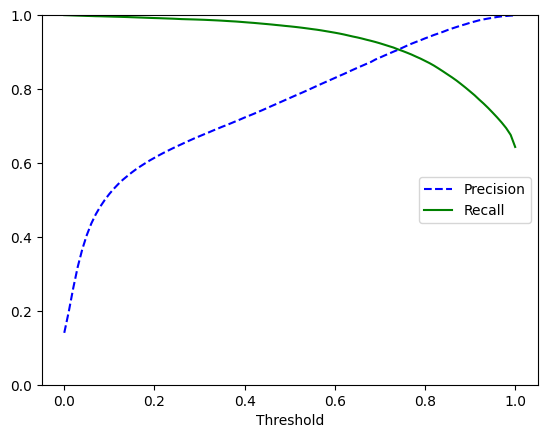

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

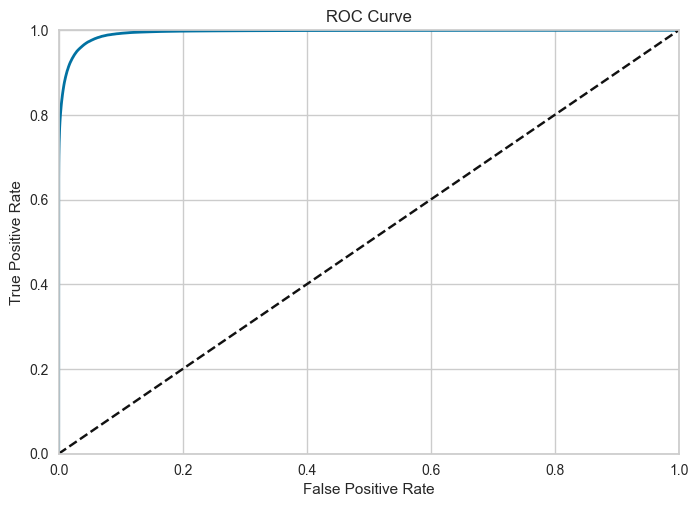

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [59]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
afspraak_specialisme,0.265020
afspraak_beschrijving,0.254113
afspraak_arts,0.212348
afstand,0.062434
afspraak_id,0.037019
afspraak_leadTime,0.022095
afspraak_duur,0.019208
patient_leeftijd,0.015731
patient_dagenSindsVorigeAfspraak,0.014960
patient_aantalAfsprakenDieDag,0.013878


##### Vergelijking modellen

In [ ]:
from pycaret.classification import ClassificationExperiment

s = ClassificationExperiment()

s.setup(data=df, target='afspraak_noShow')

In [130]:
s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9721,0.9958,0.9641,0.9527,0.9584,0.9374,0.9375,14.4310
xgboost,Extreme Gradient Boosting,0.9714,0.9956,0.9623,0.9524,0.9573,0.9358,0.9359,4.7040
lightgbm,Light Gradient Boosting Machine,0.9694,0.9953,0.9631,0.9459,0.9544,0.9314,0.9315,0.7160
rf,Random Forest Classifier,0.9685,0.9944,0.9598,0.9464,0.9530,0.9294,0.9294,4.0200
et,Extra Trees Classifier,0.9651,0.9934,0.9559,0.9402,0.9480,0.9217,0.9218,4.1990
gbc,Gradient Boosting Classifier,0.9621,0.9924,0.9601,0.9285,0.9440,0.9153,0.9156,8.1200
dt,Decision Tree Classifier,0.9534,0.9474,0.9293,0.9306,0.9300,0.8951,0.8951,0.3090
ada,Ada Boost Classifier,0.9508,0.9890,0.9307,0.9222,0.9264,0.8894,0.8895,1.6410
lr,Logistic Regression,0.9446,0.9798,0.9320,0.9043,0.9180,0.8761,0.8763,1.9870
svm,SVM - Linear Kernel,0.9325,0.9739,0.8856,0.9093,0.8972,0.8470,0.8472,0.1450
